In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/base-512x512/base.pth
/kaggle/input/global-wheat-detection/sample_submission.csv
/kaggle/input/global-wheat-detection/train.csv
/kaggle/input/global-wheat-detection/test/796707dd7.jpg
/kaggle/input/global-wheat-detection/test/cc3532ff6.jpg
/kaggle/input/global-wheat-detection/test/51f1be19e.jpg
/kaggle/input/global-wheat-detection/test/51b3e36ab.jpg
/kaggle/input/global-wheat-detection/test/f5a1f0358.jpg
/kaggle/input/global-wheat-detection/test/aac893a91.jpg
/kaggle/input/global-wheat-detection/test/348a992bb.jpg
/kaggle/input/global-wheat-detection/test/2fd875eaa.jpg
/kaggle/input/global-wheat-detection/test/cb8d261a3.jpg
/kaggle/input/global-wheat-detection/test/53f253011.jpg
/kaggle/input/global-wheat-detection/train/4b95f5e5a.jpg
/kaggle/input/global-wheat-detection/train/59d43a53f.jpg
/kaggle/input/global-wheat-detection/train/f54dedb60.jpg
/kaggle/input/global-wheat-detection/train/efa2ec01b.jpg
/kaggle/input/global-wheat-detection/train/8a8df1c28.jpg
/kaggle/input

/kaggle/input/global-wheat-detection/train/c631c7fdb.jpg
/kaggle/input/global-wheat-detection/train/fe7ecb1f4.jpg
/kaggle/input/global-wheat-detection/train/a70061d2b.jpg
/kaggle/input/global-wheat-detection/train/c89aed93e.jpg
/kaggle/input/global-wheat-detection/train/ad59fa99c.jpg
/kaggle/input/global-wheat-detection/train/20e9f1548.jpg
/kaggle/input/global-wheat-detection/train/26cfef469.jpg
/kaggle/input/global-wheat-detection/train/43e3ccd92.jpg
/kaggle/input/global-wheat-detection/train/d781eb0c1.jpg
/kaggle/input/global-wheat-detection/train/bead3cebe.jpg
/kaggle/input/global-wheat-detection/train/1b10b9fa1.jpg
/kaggle/input/global-wheat-detection/train/7e6a307fd.jpg
/kaggle/input/global-wheat-detection/train/1def04f70.jpg
/kaggle/input/global-wheat-detection/train/2d3e3f783.jpg
/kaggle/input/global-wheat-detection/train/b35fb3de5.jpg
/kaggle/input/global-wheat-detection/train/da8c686cb.jpg
/kaggle/input/global-wheat-detection/train/de2a3cf37.jpg
/kaggle/input/global-wheat-dete

In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.pytorch.transforms import ToTensorV2, ToTensor

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

In [3]:
train_df=pd.read_csv('../input/global-wheat-detection/train.csv')

In [4]:
df=train_df

In [5]:
df=df[['image_id', 'source']].drop_duplicates()


In [6]:
s_map={'arvalis_1':1,'ethz_1':2,'arvalis_3':3,'rres_1':4,'arvalis_2':5,'usask_1':6,'inrae_1':7,}

In [7]:
df['mapping']=df.source.map(s_map)

In [8]:
h=[i for i in range(len(df))]

In [9]:
df.set_index(pd.Index(h), inplace = True) 

In [10]:
df['folds']=-1

In [11]:
from sklearn import model_selection

In [12]:
kf = model_selection.StratifiedKFold(n_splits=5)


In [13]:
y=df.mapping.values

In [14]:
for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
    df.loc[v_, 'folds'] = f

In [15]:
train_df['folds']=-1

In [16]:
mapp=df.groupby(['image_id']).folds.mean()
train_df.folds=train_df.image_id.map(mapp)

In [17]:
import re
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

In [18]:
dff=train_df
dff['area']=train_df.w*train_df.h
dff.head()

,image_id,width,height,source,folds,x,y,w,h,area
0,b6ab77fd7,1024,1024,usask_1,0,834.0,222.0,56.0,36.0,2016.0
1,b6ab77fd7,1024,1024,usask_1,0,226.0,548.0,130.0,58.0,7540.0
2,b6ab77fd7,1024,1024,usask_1,0,377.0,504.0,74.0,160.0,11840.0
3,b6ab77fd7,1024,1024,usask_1,0,834.0,95.0,109.0,107.0,11663.0
4,b6ab77fd7,1024,1024,usask_1,0,26.0,144.0,124.0,117.0,14508.0


In [19]:
'''filt2=(dff.area<150000)
dff=dff[filt2]'''

'filt2=(dff.area<150000)\ndff=dff[filt2]'

In [20]:
filt1=(dff.area>25)
dff=dff[filt1]


In [21]:
dff['x_min']=dff.x
dff['y_min']=dff.y
dff['x_max']=dff.x+dff.w
dff['y_max']=dff.y+dff.h


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [22]:
train_df = dff[['image_id', 'x_min', 'y_min', 'x_max', 'y_max', 'width', 'height', 'area', 'source','folds']]
train_df.head()

,image_id,x_min,y_min,x_max,y_max,width,height,area,source,folds
0,b6ab77fd7,834.0,222.0,890.0,258.0,1024,1024,2016.0,usask_1,0
1,b6ab77fd7,226.0,548.0,356.0,606.0,1024,1024,7540.0,usask_1,0
2,b6ab77fd7,377.0,504.0,451.0,664.0,1024,1024,11840.0,usask_1,0
3,b6ab77fd7,834.0,95.0,943.0,202.0,1024,1024,11663.0,usask_1,0
4,b6ab77fd7,26.0,144.0,150.0,261.0,1024,1024,14508.0,usask_1,0


In [23]:
def get_train_transform():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.3),
            
            
           A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                    A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9)],p=0.9),
            
            A.ToGray(p=0.05),
            A.RandomShadow(p=0.1),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            
            A.Cutout(num_holes=5, max_h_size=100, max_w_size=100, fill_value=[0,0,0], p=0.3),
            ToTensorV2(p=1.0),
        ],p=1.0,
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transform():
    return A.Compose(
        [
            
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [24]:
class WheatDataset(Dataset):

    def __init__(self, df, image_dir,folds,transforms=None):
        super().__init__()
        self.df = df[df.folds.isin(folds)].reset_index(drop=True)
        self.image_ids = self.df['image_id'].unique()
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        
            
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
            

        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
        
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            if (len(sample['bboxes'])>0):
                target['boxes']=torch.as_tensor(sample['bboxes'],dtype=torch.float32)
            else:
                target['boxes']= torch.linspace(0,3,steps=4,dtype=torch.float32)
                target['boxes']=target['boxes'].reshape(-1,4)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [25]:
DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'

In [36]:
def collate_fn(batch):
    return tuple(zip(*batch))
train_dataset = WheatDataset(train_df,DIR_TRAIN,[0, 1, 3, 4],get_train_transform())
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loaders = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

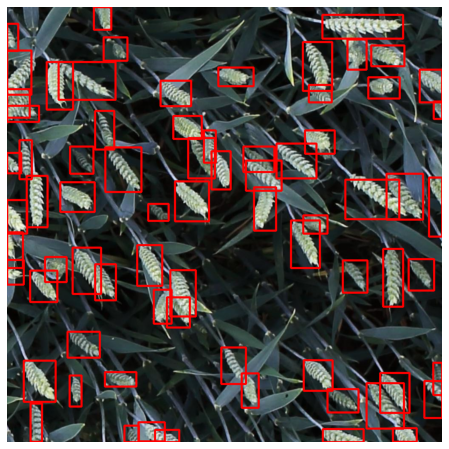

In [37]:
images, targets, image_ids = next(iter(train_data_loaders))
images = list(image.to(torch.device('cpu')) for image in images)
targets = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in targets]
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [28]:
DIR_WEIGHTS = '.../input/base-512x512'

WEIGHTS_FILE = '../input/base-512x512/base.pth'


In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [30]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
backbone = resnet_fpn_backbone('resnet50',False)
model = FasterRCNN(backbone, num_classes=2)

In [31]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE))
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [32]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [38]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.00001)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
#lr_scheduler = None

num_epochs = 15

In [34]:
# CUSTOM LEARNING SCHEUDLE
LR_START = 1e-5
LR_MAX = 1e-3
LR_RAMPUP_EPOCHS = 2
LR_SUSTAIN_EPOCHS = 0
LR_STEP_DECAY = 0.75

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//2)
    return lr
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lrfn)


In [39]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loaders:
        
        images = list(image.to(device) for image in images)
        targets= [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        
        losses.backward()
        optimizer.step()

        if itr % 70 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}") 

Iteration #70 loss: 0.841238260269165
Iteration #140 loss: 0.8599201440811157
Iteration #210 loss: 0.7569471597671509
Iteration #280 loss: 0.5838412046432495
Epoch #0 loss: 0.7615028090730926
Iteration #350 loss: 0.7184110879898071
Iteration #420 loss: 0.7077255845069885
Iteration #490 loss: 0.8563103675842285
Iteration #560 loss: 0.7605545520782471
Iteration #630 loss: 0.6886587142944336
Epoch #1 loss: 0.744904935712645
Iteration #700 loss: 0.6410425901412964
Iteration #770 loss: 0.6953735947608948
Iteration #840 loss: 0.8330271244049072
Iteration #910 loss: 0.7331757545471191
Iteration #980 loss: 0.7905268669128418
Epoch #2 loss: 0.7397006937032621
Iteration #1050 loss: 0.9431936144828796
Iteration #1120 loss: 0.8601349592208862
Iteration #1190 loss: 0.7188778519630432
Iteration #1260 loss: 0.7393895387649536
Iteration #1330 loss: 0.7793138027191162
Epoch #3 loss: 0.7265809148373689
Iteration #1400 loss: 0.6991634964942932
Iteration #1470 loss: 0.6049323678016663
Iteration #1540 loss

In [ ]:
torch.save(model.state_dict(), '50model2.pth')